<div style="display:block">
    <div >
        <h5  style="color:#4780B2; text-align: center; font-size:25px;">PyTorch 101 for Vision Machine Learning</h5>
        <div style="width: 90%; text-align: center; display: inline-block;"><i>Author: </i> <strong>Shubhra Prakash</strong> 
            <br>  <div style=" text-align: right;"><i>Modified: Dec 28th, 2022</i></div>
        </div>
    </div>
</div>

# Objectives

* Train a number detection model for MNIST Dataset
* Solve the following problem: Write a neural network that can:

1. take 2 inputs:
    1. an image from the MNIST dataset (say 5), and
    2. a random number between 0 and 9, (say 7)
2. and gives two outputs:
    1. the "number" that was represented by the MNIST image (predict 5), and
    2. the "sum" of this number with the random number and the input image to the network (predict 5 + 7 = 12)
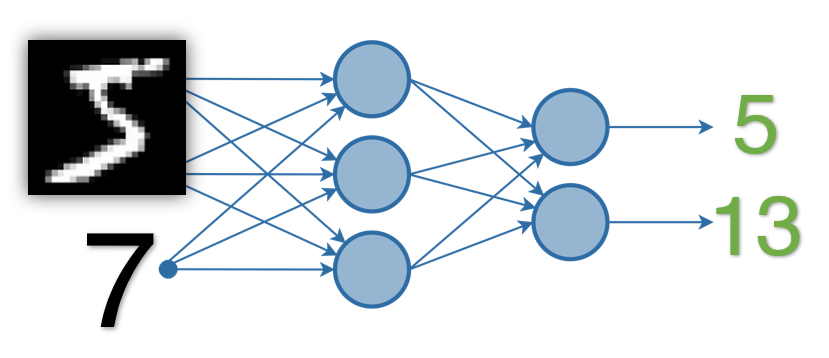   
3. you can mix fully connected layers and convolution layers
4. you can use one-hot encoding to represent the random number input and the "summed" output.
5. Random number (7) can be represented as 0 0 0 0 0 0 0 1 0 0
6. Sum (13) can be represented as:
    7. 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0



# Solution

1. Please find the readme in the root folder
2. Data Representation: images, random numbers, image label and number labels are tensors created using pytorch
3. Data generation strategy:
    * Image: MNIST function from pytorch. DataLoader is used or batch creation. batch size same as images 
    * Random number:
        * Random number creation using random.randint (list of integers)
        * One hot encoding using sklearn
        * Datset creation using Dataset function from pytorch
        * DataLoader is used or batch creation. batch size same as images 
4. Combining the two inputs:
    * Using cat function from torch
    * see the diagram below
    
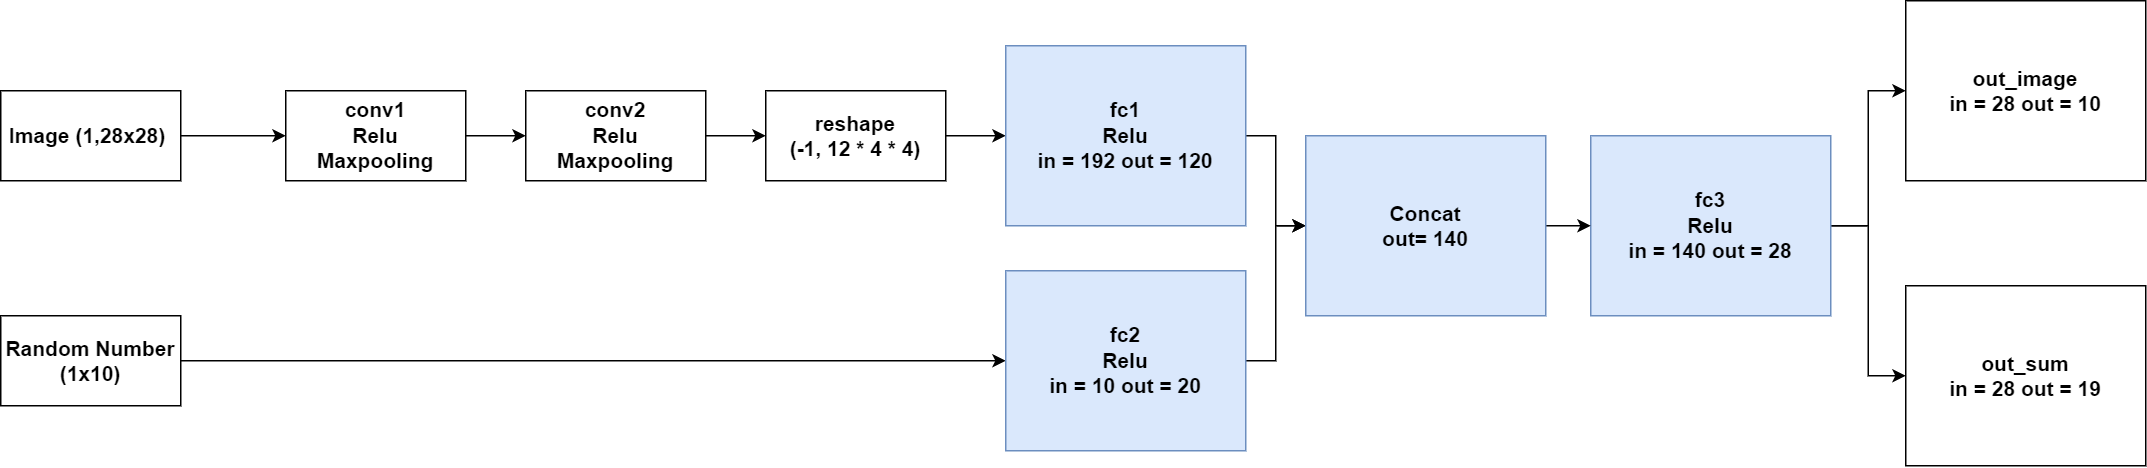

5. Evaluating Results: Accuracy
6. Image Classification Accuracy: 59093/60000 = 0.9848
    * Sum Accuracy: 58476/60000 = 0.9746
7. Loss Function: Cross entropy
    * total_loss = 0.8*(loss1(Image)) + 0.2*(loss2(Sum))
    * Cross entropy function  takes into account the difference between the predicted and actual output of the model and penalizes the model if the difference is too large. It is a popular choice for classification problems since it takes into account the probability of a given class and penalizes heavily wrong predictions.
    
8. Model and all input were sent to cuda for computation

10 .Please find logs in readme file


# Importing Libraries

Importing the necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

#import MNIST dataset
from torchvision.datasets import MNIST

#import data loader and dataset
from torch.utils.data import DataLoader,Dataset

from torchvision.utils import make_grid
from tqdm import tqdm

# imports random module
import random

In [2]:
import numpy as np
import matplotlib.pyplot as plt

torch.set_printoptions(linewidth=120)

In [3]:
# Checking if Cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# HyperParameters

In [4]:
#define hyperparameters
batch_size = 50
num_epochs = 10
learning_rate = 0.01

# Adding Dataset

In [5]:
#load the MNIST dataset
train_dataset = MNIST(root='data/',train=True,transform=transforms.ToTensor(),download=True)
test_dataset = MNIST(root='data/',train=False,transform=transforms.ToTensor(),download=True)

#create data loaders
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

## Exploring Datasets

In [6]:
print(f"Train Size:{len(train_dataset)},Test Size:{len(test_dataset)}")

Train Size:60000,Test Size:10000


## Class Distribution

In [7]:
def plot_distribution_classes(x_values, y_values):
    # Figure Size
    fig = plt.figure(figsize =(10, 7))

    # Horizontal Bar Plot
    plt.bar(x_values,y_values)

    # Show Plot
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.title("Distribution of classes")
    fig.show()

In [8]:
print(train_dataset.targets)
print(train_dataset.targets.bincount())

tensor([5, 0, 4,  ..., 5, 6, 8])
tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])


### Train Data

C:\Users\shubh\AppData\Local\Temp\ipykernel_12540\3192017234.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


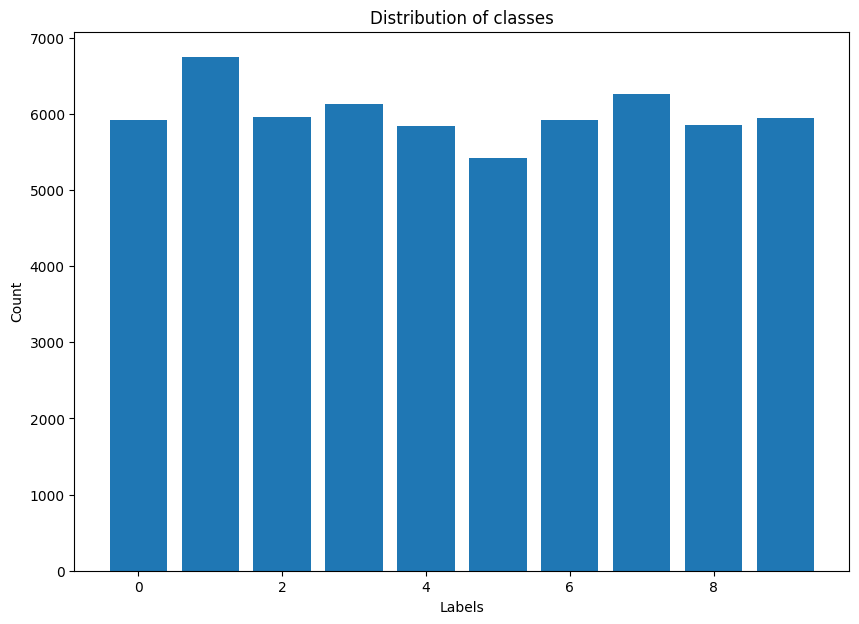

In [9]:
x = np.sort(train_dataset.targets.unique())
y = train_dataset.targets.bincount()

plot_distribution_classes(x, y)

In [10]:
print(test_dataset.targets)
print(test_dataset.targets.bincount())

tensor([7, 2, 1,  ..., 4, 5, 6])
tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])


## Visualizing Images

labels: tensor([0, 9, 7, 2, 8, 7, 4, 5, 0, 5, 8, 1, 5, 4, 2, 2, 2, 4, 2, 4, 2, 0, 5, 7, 7, 3, 2, 2, 1, 8, 7, 0, 6, 2, 0, 2, 2,
        7, 3, 6, 4, 9, 4, 9, 8, 6, 7, 5, 8, 3])


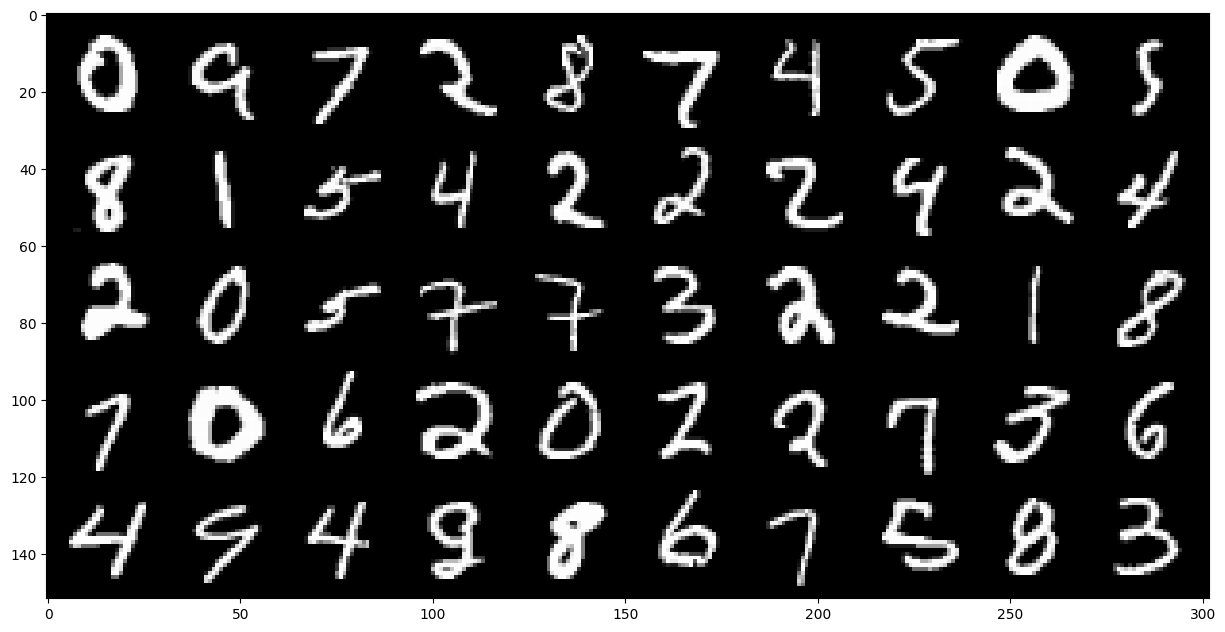

In [11]:
batch = next(iter(train_loader))
images, labels = batch

grid = make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print('labels:', labels)

# Define Model1

## Writing/Testing the MNIST Classifier

In [12]:
#define a convolutional neural network

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
  
    def forward(self, t):
        # input layer
        x = t

        # conv1 layer
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # 28 | 24 | 12

        # conv2 layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # 12 | 8 | 4 >> 12x4x4

        # reshapre
        x = x.reshape(-1, 12 * 4 * 4)

        # fc1 layer
        x = self.fc1(x)
        x = F.relu(x)

        # fc2 layer
        x = self.fc2(x)
        x = F.relu(x)

        # output layer
        x = self.out(x)
        # x = F.softmax(x, dim=1)
        return x

In [13]:
#instantiate the model
network = Network().to(device)
# network = Network()

In [14]:
#define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(),lr=learning_rate)

In [15]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [16]:
%%time
#train the model
for epoch in range(num_epochs):
    total_loss = 0
    total_correct = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch_idx, (data,target) in enumerate(tepoch):
            #forward pass
            data, target = data.to(device), target.to(device)
            output = network(data)
            loss = criterion(output,target)

            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_correct += get_num_correct(output, target)

        print(
            "epoch", epoch, 
            "total_correct:", total_correct, 
            "loss:", total_loss
        )

In [17]:
59350/60000

0.9891666666666666

In [18]:
# #test the model
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for data, target in test_loader:
#         output = network(data)
#         _, predicted = torch.max(output.data,1)
#         total += target.size(0)
#         correct += (predicted==target).sum().item()
        
#     print('Test Accuracy: {} %'.format(100*correct/total))

Test Accuracy: ~98.14 

# Define Model2 to find sum of image and Random number

## RandomNumber Dataset

In [19]:
# Creating a list of random number
rand_len=len(train_loader.dataset.targets)
rand_list=[random.randint(0, 9) for x in range(rand_len)]
print(f"Min:{min(rand_list)},Max:{max(rand_list)},Len:{len(rand_list)}")

Min:0,Max:9,Len:60000


### One Hot Encoding

In [20]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# define example
data = rand_list
values = array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded_num = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded_num)

[7 2 5 ... 5 6 1]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [21]:
# onehot_encoded_num=[x.reshape(1,-1) for x in onehot_encoded_num]

In [22]:
onehot_encoded_num

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

### DataLoader for Random Number

In [23]:
class rand_num(Dataset):
    def __init__(self):
        self.x=torch.tensor(onehot_encoded_num,device="cuda", requires_grad=True, dtype=torch.float32)
        self.y=torch.tensor(rand_list,device="cuda")
#         self.y=torch.tensor(temp_var_sum,device="cuda")
        
        self.n_samples=len(self.y)
        
    def __getitem__(self,index):
        return self.x[index],self.y[index]
    def __len__(self):
        return self.n_samples
    
dataset_num=rand_num()
train_loader_num=DataLoader(dataset=dataset_num,batch_size=batch_size,shuffle=True)

In [24]:
next(iter(train_loader_num))

[tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1

In [25]:
#define a convolutional neural network

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120) # For images
        self.fc2 = nn.Linear(in_features=10, out_features=20) # For Number
        
        self.fc3 = nn.Linear(in_features=140, out_features=28) # Combination
        self.out_i = nn.Linear(in_features=28, out_features=10)
        self.out_rn = nn.Linear(in_features=28, out_features=19)
  
    def forward(self, t,rand_num_ohe):
        # input layer
        x = t#.to(device)
#         rand_num_ohe=rand_num_ohe.to(device)
#         rand_num_ohe=rand_num_ohe.reshape(1,-1)

        # conv1 layer
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # 28 | 24 | 12

        # conv2 layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # 12 | 8 | 4 >> 12x4x4

        # reshapre
        x = x.reshape(-1, 12 * 4 * 4)

        # fc1 layer for images
        x = self.fc1(x)
        x = F.relu(x)
        
        # fc2 layer for rand_num_ohe
        x_r = self.fc2(rand_num_ohe)
        x_r = F.relu(x_r)
        
        #Concatenate the inputs 
#         print(x.shape)
        
#         print(x_r.shape)
        input_concat = torch.cat((x, x_r), dim=1)
        
        # fc2 layer for rand_num_ohe
        x_ir = self.fc3(input_concat)
        x_ir = F.relu(x_ir)

        # output layer
        x_image = self.out_i(x_ir)
        x_sum = self.out_rn(x_ir)
        # x = F.softmax(x, dim=1)
        return x_image,x_sum

In [26]:
network = Network().to("cuda")

print(network)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=10, out_features=20, bias=True)
  (fc3): Linear(in_features=140, out_features=28, bias=True)
  (out_i): Linear(in_features=28, out_features=10, bias=True)
  (out_rn): Linear(in_features=28, out_features=19, bias=True)
)


In [27]:
for name, param in network.named_parameters():
    print(name, '\t\t', param.shape)

conv1.weight 		 torch.Size([6, 1, 5, 5])
conv1.bias 		 torch.Size([6])
conv2.weight 		 torch.Size([12, 6, 5, 5])
conv2.bias 		 torch.Size([12])
fc1.weight 		 torch.Size([120, 192])
fc1.bias 		 torch.Size([120])
fc2.weight 		 torch.Size([20, 10])
fc2.bias 		 torch.Size([20])
fc3.weight 		 torch.Size([28, 140])
fc3.bias 		 torch.Size([28])
out_i.weight 		 torch.Size([10, 28])
out_i.bias 		 torch.Size([10])
out_rn.weight 		 torch.Size([19, 28])
out_rn.bias 		 torch.Size([19])


# Training the model

In [28]:
#define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(),lr=learning_rate)

In [29]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [30]:
#train the model
for epoch in range(num_epochs):
    total_loss = 0
    total_correct_image = 0
    total_correct_num = 0
#     with tqdm(train_loader, unit="batch") as tepoch:
#     for batch_idx, (data_im,target_im) in enumerate(tepoch):
        #forward pass
#             data, target = data.to(device), target.to(device)
    for batch_image,batch_num in zip(train_loader,train_loader_num): # Get Batch
        images, labels_image = batch_image 
        rand_num_btch, labels_num = batch_num 
        #cuda
        images=images.to(device)
        labels_image =labels_image.to(device)
        
        rand_num_btch=rand_num_btch.to(device)
        labels_num=labels_num.to(device)
        
#         sum_number=labels_image+labels_num
#         sum_number2 = sum_number.clone().detach().requires_grad_(False)
#         sum_number2 = labels_num
#         sum_number=sum_number.to(device)
        sum_num=labels_image+labels_num
        
        
        output = network(images,rand_num_btch)
        loss1 = criterion(output[0],labels_image)
        loss2 = criterion(output[1],sum_num)
        total_loss = 0.8*(loss1) + 0.2*(loss2)

        #backward pass
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        total_loss += total_loss.item()
        total_correct_image += get_num_correct(output[0], labels_image)
        total_correct_num += get_num_correct(output[1], sum_num)

    print(
        "epoch", epoch, 
        "total_correct_image:", total_correct_image, 
        "total_correct_sum:", total_correct_num, 
        "loss:", total_loss
    )

epoch 0 total_correct_image: 56770 total_correct_sum: 38823 loss: tensor(0.1702, device='cuda:0', grad_fn=<AddBackward0>)
epoch 1 total_correct_image: 58472 total_correct_sum: 57245 loss: tensor(0.5585, device='cuda:0', grad_fn=<AddBackward0>)
epoch 2 total_correct_image: 58681 total_correct_sum: 57908 loss: tensor(0.9654, device='cuda:0', grad_fn=<AddBackward0>)
epoch 3 total_correct_image: 58864 total_correct_sum: 58040 loss: tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)
epoch 4 total_correct_image: 58873 total_correct_sum: 58088 loss: tensor(0.6852, device='cuda:0', grad_fn=<AddBackward0>)
epoch 5 total_correct_image: 58966 total_correct_sum: 58253 loss: tensor(0.1924, device='cuda:0', grad_fn=<AddBackward0>)
epoch 6 total_correct_image: 58947 total_correct_sum: 58227 loss: tensor(0.4302, device='cuda:0', grad_fn=<AddBackward0>)
epoch 7 total_correct_image: 59044 total_correct_sum: 58374 loss: tensor(0.1567, device='cuda:0', grad_fn=<AddBackward0>)
epoch 8 total_correct_im

In [1]:
# Image Accuracy:
59093 /60000


0.9848833333333333

In [2]:
# Sum Accuracy:
58476  /60000

0.9746